In [10]:
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [12]:
def plot_pwv_for_date(
    date,
    data_dir="data/src/",
    file_template="PWV_flow_._{year}_{month:02d}_.nc",
    central_lon=-160,
    cmap='jet',
    vmin=0,
    vmax=60,
    contour_step=10
):
    """
    Строит карту PWV для заданной даты, открывая только файл нужного месяца.
    date: строка или datetime, например "2012-10-15 12:00"
    data_dir: каталог, где лежат файлы NetCDF
    file_template: шаблон имени файла с плейсхолдерами {year} и {month}
    Остальные параметры настраивают визуализацию.
    """
    # Парсинг даты
    date = date[4:].replace("_", " ")
    date[:-2] + ":" + date[-2:]
    ts = pd.to_datetime(date)
    year = ts.year
    month = ts.month

    # Формирование пути к файлу по шаблону
    pattern = file_template.format(year=year, month=month)
    file_path = Path(data_dir, pattern)
    print(f"Input timestamp: {ts}")

    # Открытие одного файла
    ds = xr.open_dataset(file_path)
    ds = ds.sortby('lon')

    # Выбор ближайшего временного среза
    slice_ = ds['PWV'].sel(timestamp=np.datetime64(ts), method='nearest')
    print(f"Founded slice with timestamp: {slice_.timestamp.values}")

    # Построение карты
    plt.figure(figsize=(20, 9))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_lon))
    slice_.T.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs={'label': 'PWV (kg/m²)'}
    )
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    ax.set_title(f'PWV for {ts.strftime("%Y-%m-%d %H:%M")}')

    # Добавление изолиний
    levels = np.arange(vmin, vmax + contour_step, contour_step)
    contours = plt.contour(
        slice_.lon,
        slice_.lat,
        slice_.T.squeeze(),
        levels=levels,
        colors='#222222',
        linewidths=0.3,
        transform=ccrs.PlateCarree()
    )
    plt.clabel(contours, inline=True, fontsize=8, fmt='%d')
    plt.show()


Input timestamp: 2012-01-01 00:00:00
Founded slice with timestamp: 2012-01-01T00:00:00.000000000


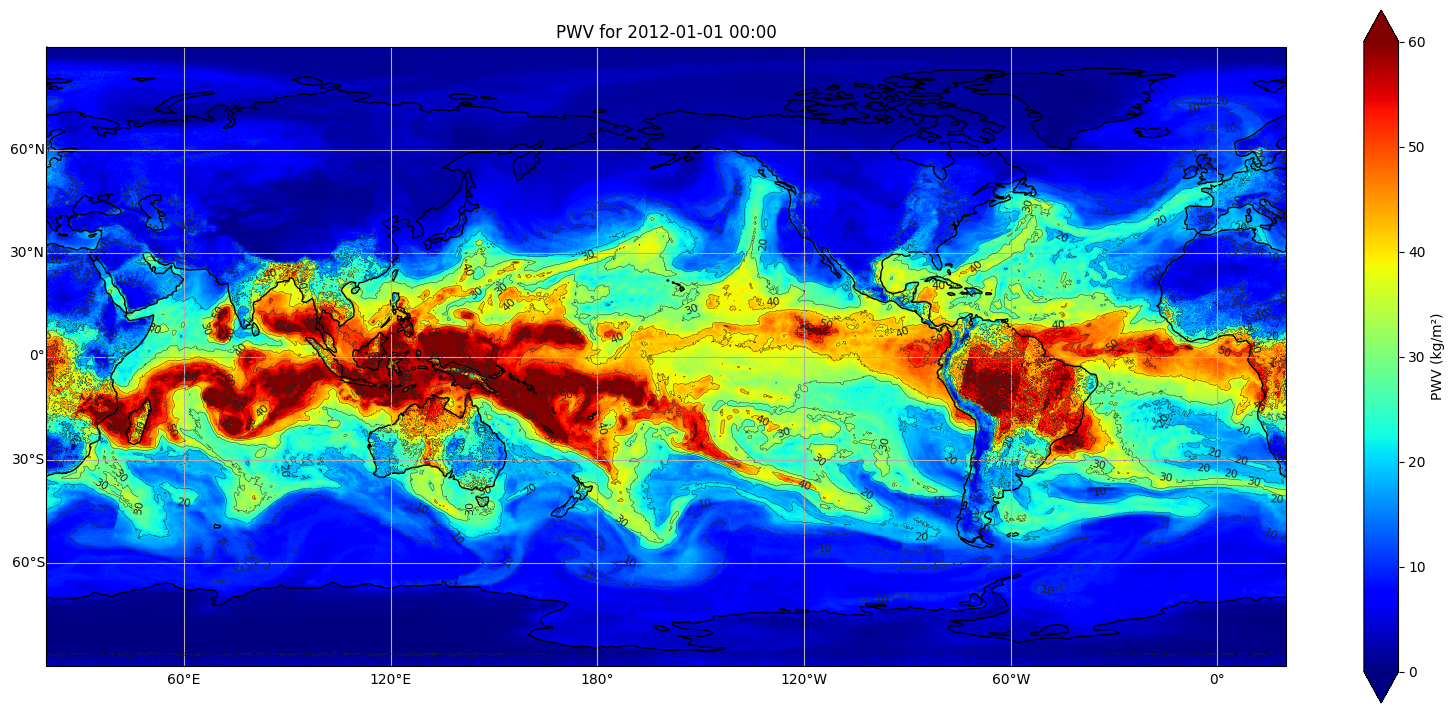

In [13]:
plot_pwv_for_date("PWV_2012-01-01_0000")

In [ ]:
import json
from pathlib import Path

VIZ_DIR = Path("data/frames/frames_pil_scheme")
MANIFEST_PATH = Path("data/frames/frames_pil_manifest.json")

manifest = [{"data": {
    "image": f"/data/local-files/?d=data/images/{p.name}",
    "filename": p.name
    }
} for p in sorted(VIZ_DIR.glob("*.png"))]
manifest[0]
with open(MANIFEST_PATH, "w", encoding="utf-8") as fp:
    json.dump(manifest, fp, ensure_ascii=False, indent=4)

## test labels

In [62]:
from scipy.ndimage import label, find_objects

In [89]:
# Порог для PWV (в метрах, если данные в кг/м^2, нужно пересчитать)
PWV_THRESHOLD = 60  # 2 см

# Географические координаты
lon = ds['lon'].values
lat = ds['lat'].values
print(lon)
# print(lat)

[1.25000e-01 3.75000e-01 6.25000e-01 ... 3.59375e+02 3.59625e+02
 3.59875e+02]


(slice(50, 90, None), slice(418, 435, None))
(slice(126, 214, None), slice(371, 400, None))
(slice(196, 244, None), slice(408, 442, None))
(slice(242, 290, None), slice(370, 424, None))
(slice(358, 395, None), slice(390, 423, None))
(slice(364, 387, None), slice(353, 377, None))
(slice(397, 434, None), slice(374, 413, None))
(slice(406, 498, None), slice(327, 375, None))
(slice(469, 499, None), slice(378, 396, None))
(slice(505, 664, None), slice(366, 459, None))
(slice(537, 608, None), slice(326, 348, None))
(slice(667, 694, None), slice(397, 426, None))
(slice(1073, 1117, None), slice(360, 423, None))
(slice(1109, 1138, None), slice(376, 407, None))
(slice(1183, 1207, None), slice(429, 464, None))


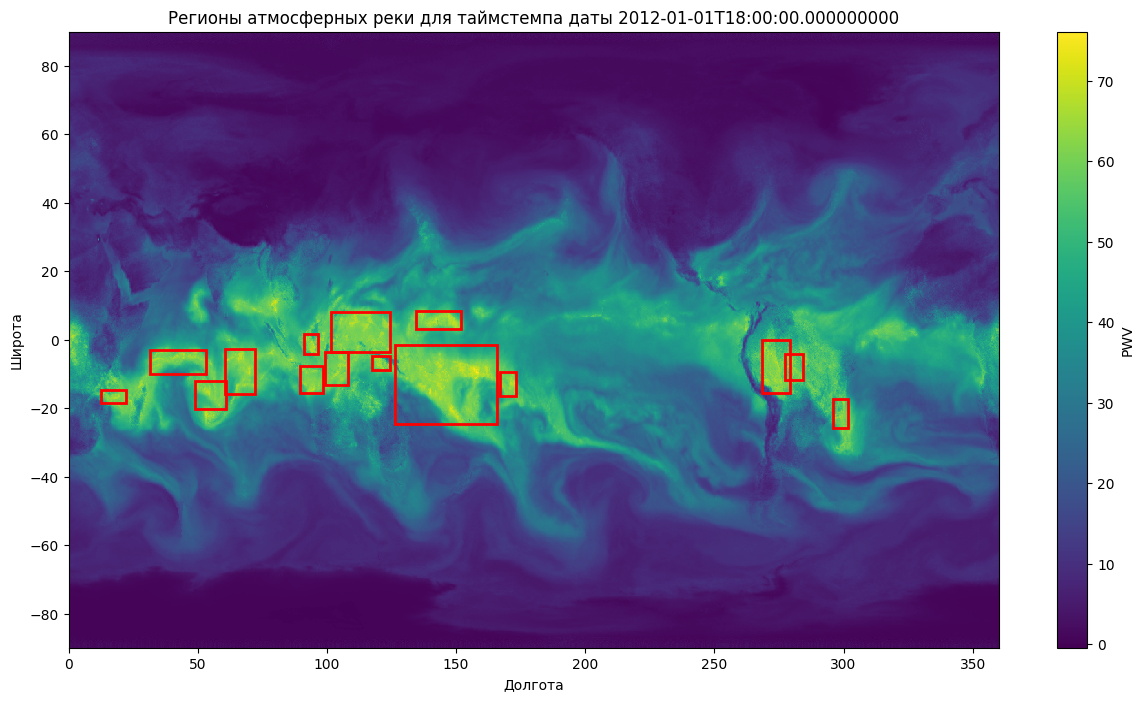

In [ ]:
# Функция для вычисления длины и ширины области
def calculate_geometry(region_slice):
    lon_extent = (lon[region_slice[0].stop - 1] - lon[region_slice[0].start])
    lat_extent = (lat[region_slice[1].stop - 1] - lat[region_slice[1].start])
    return lon_extent, lat_extent

# Функция для детекции атмосферных рек
def detect_AR(timestamp_index):
    # Бинаризация поля PWV для выбранного таймстемпа
    binary_pwv = (ds['PWV'].isel(timestamp=timestamp_index) >= PWV_THRESHOLD)

    # Идентификация связанных областей
    labeled_array, num_features = label(binary_pwv)

    # Фильтрация по геометрическим критериям
    AR_candidates = []
    for region_slice in find_objects(labeled_array):
        if region_slice is not None:
            lon_extent, lat_extent = calculate_geometry(region_slice)

            # Проверка условий для атмосферных рек
            if lon_extent >= 10 and lat_extent <= 5:
                print(region_slice)
                AR_candidates.append(region_slice)

    return AR_candidates

# Функция для визуализации результатов
def plot_AR(timestamp_index):
    AR_candidates = detect_AR(timestamp_index)

    plt.figure(figsize=(15, 8))
    plt.pcolormesh(lon, lat, ds['PWV'].isel(timestamp=timestamp_index).T, shading='auto')

    for region in AR_candidates:
        plt.gca().add_patch(plt.Rectangle(
            (lon[region[0].start], lat[region[1].start]),
            lon[region[0].stop - 1] - lon[region[0].start],
            lat[region[1].stop - 1] - lat[region[1].start],
            fill=False, edgecolor='red', linewidth=2
        ))
        

    plt.colorbar(label='PWV')
    # plt.title(f'Регионы атмосферных реки для таймстемпа {timestamp_index}')
    plt.title(f'Регионы атмосферных реки для таймстемпа даты {ds["timestamp"].values[timestamp_index]}')
    plt.xlabel('Долгота')
    plt.ylabel('Широта')
    plt.show()

# Пример вызова для первого таймстемпа
plot_AR(6)


IndexError: index 1 is out of bounds for axis 0 with size 1

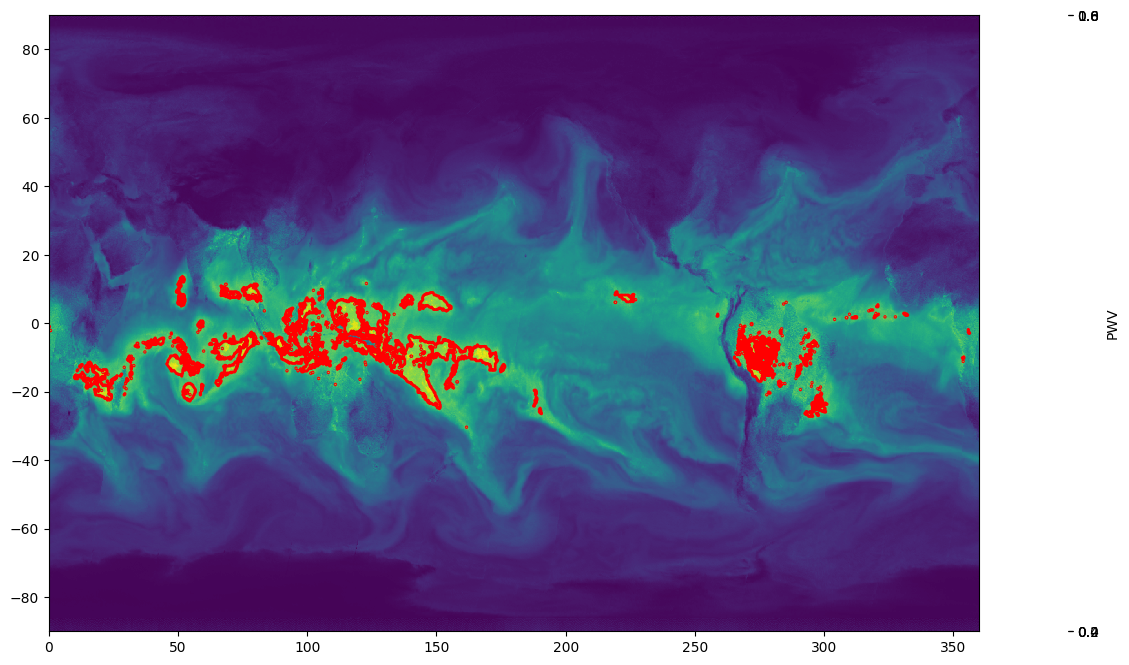

In [98]:
# Функция для вычисления длины и ширины области
def calculate_geometry(region_slice):
    lon_extent = (lon[region_slice[0].stop - 1] - lon[region_slice[0].start])
    lat_extent = (lat[region_slice[1].stop - 1] - lat[region_slice[1].start])
    return lon_extent, lat_extent

# Функция для детекции атмосферных рек
def detect_AR(timestamp_index):
    # Бинаризация поля PWV для выбранного таймстемпа
    binary_pwv = (ds['PWV'].isel(timestamp=timestamp_index) >= PWV_THRESHOLD)

    # Идентификация связанных областей
    labeled_array, num_features = label(binary_pwv)

    # Фильтрация по геометрическим критериям
    AR_candidates = []
    for region_slice in find_objects(labeled_array):
        if region_slice is not None:
            lon_extent, lat_extent = calculate_geometry(region_slice)

            # Проверка условий для атмосферных рек
            if lon_extent >= 20 and lat_extent <= 20:
                AR_candidates.append((labeled_array == labeled_array[region_slice][0, 0]))

    return AR_candidates

# Функция для визуализации результатов с контурами
def plot_AR(timestamp_index):
    AR_candidates = detect_AR(timestamp_index)

    plt.figure(figsize=(15, 8))
    plt.pcolormesh(ds['lon'], ds['lat'], ds['PWV'].isel(timestamp=timestamp_index).T, shading='auto')

    for candidate in AR_candidates:
        plt.contour(lon, lat, candidate.T, levels=[0.5], colors='red', linewidths=2)

    plt.colorbar(label='PWV')
    plt.title(f'Детектированные атмосферные реки для таймстемпа {timestamp_index}')
    plt.xlabel('Долгота')
    plt.ylabel('Широта')
    plt.show()

# Пример вызова для первого таймстемпа
plot_AR(0)


## o3

In [103]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, binary_closing, generate_binary_structure
from skimage.measure import regionprops
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


[{'bbox': (120, 409, 132, 428), 'length_km': np.float64(500.3771699005143), 'width_km': np.float64(295.87649180571657), 'label': 17}, {'bbox': (145, 377, 178, 389), 'length_km': np.float64(885.0763805492178), 'width_km': np.float64(305.7860482725366), 'label': 20}, {'bbox': (197, 305, 211, 340), 'length_km': np.float64(945.1568764787492), 'width_km': np.float64(356.5553632428348), 'label': 26}, {'bbox': (207, 430, 227, 451), 'length_km': np.float64(555.9746332227937), 'width_km': np.float64(495.91088328328425), 'label': 27}, {'bbox': (266, 314, 297, 331), 'length_km': np.float64(822.8073830581836), 'width_km': np.float64(444.7797065782349), 'label': 35}, {'bbox': (544, 327, 564, 342), 'length_km': np.float64(524.9080513108073), 'width_km': np.float64(389.1822432559556), 'label': 73}, {'bbox': (882, 326, 909, 335), 'length_km': np.float64(716.7814221669797), 'width_km': np.float64(222.38985328911753), 'label': 86}]


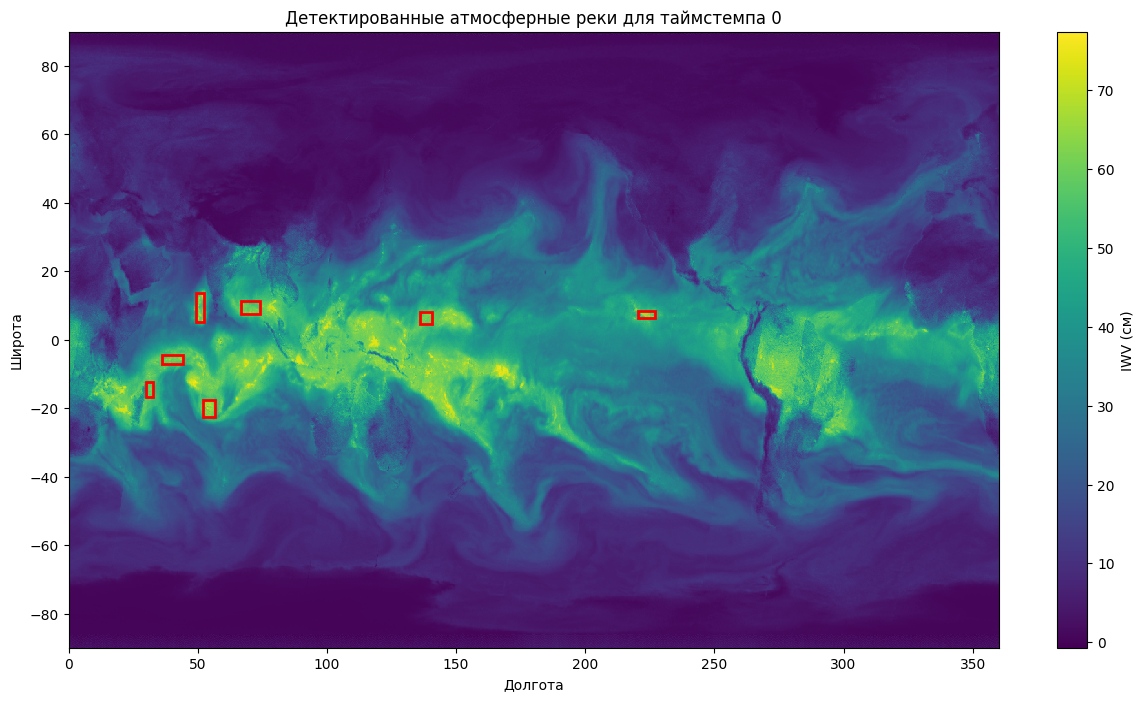

In [112]:

# Предположим, что переменная называется 'IWV' и измеряется в сантиметрах
iwv_data = ds['PWV']

# Географические координаты (предполагается, что они одномерные)
lons = ds['lon'].values  # например, от 0 до 360 или -180 до 180
lats = ds['lat'].values  # одномерный массив широт

# Порог для выделения влагонасыщенных областей (IWV ≥ 2 см)
IWV_THRESHOLD = 60  # см

# Геометрические критерии для атмосферной реки (АР)
MIN_LENGTH_KM = 500  # длина ≥ 2000 км
MAX_WIDTH_KM  = 500  # ширина ≤ 1000 км

# =============================================================================
# 2. Вспомогательные функции
# =============================================================================

def haversine(lon1, lat1, lon2, lat2):
    """
    Вычисление расстояния между двумя точками на сфере по формуле Хаверсина.
    Все аргументы задаются в градусах; результат – расстояние в километрах.
    """
    # Переводим координаты в радианы
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Радиус Земли (км)
    return c * r

# =============================================================================
# 3. Функция детекции атмосферных рек
# =============================================================================

def detect_AR(timestamp_index):
    """
    Для выбранного таймстемпа:
      1. Бинаризует поле IWV по порогу.
      2. Применяет морфологическое закрытие для сглаживания.
      3. Выделяет связанные области (методом label).
      4. Для каждой области рассчитывает географические размеры (с использованием формулы Хаверсина).
      5. Отбирает кандидаты, удовлетворяющие условиям:
           - Длина (наибольшее измерение) ≥ 2000 км
           - Ширина (наименьшее измерение) ≤ 1000 км
    Возвращает список найденных кандидатов и массив с метками объектов.
    """
    # Извлекаем поле IWV для выбранного таймстемпа
    iwv_field = iwv_data.isel(timestamp=timestamp_index).values

    # Бинаризация по фиксированному порогу
    binary_iwv = (iwv_field >= IWV_THRESHOLD)

    # Применяем морфологическое закрытие (связность 8, можно настроить число итераций)
    structure = generate_binary_structure(2, 2)  # 8-связность
    binary_iwv = binary_closing(binary_iwv, structure=structure, iterations=2)

    # Выделяем связанные области
    labeled_array, num_features = label(binary_iwv)

    # Рассчитываем свойства регионов (bounding box и т.д.)
    regions = regionprops(labeled_array)

    AR_candidates = []

    # Проходим по всем регионам
    for region in regions:
        # Получаем ограничивающий прямоугольник (bbox) в виде (min_row, min_col, max_row, max_col)
        # ВНИМАНИЕ: в зависимости от порядка осей в вашем массиве может потребоваться корректировка!
        min_row, min_col, max_row, max_col = region.bbox

        # Преобразуем индексы в географические координаты.
        # Предположим, что первая ось соответствует долготе, а вторая – широте.
        # Если у вас наоборот (lat, lon), поменяйте индексы местами.
        min_lon = lons[min_row]
        max_lon = lons[max_row - 1]
        min_lat = lats[min_col]
        max_lat = lats[max_col - 1]

        # Для расчёта расстояния выбираем центральные точки по широте и долготе
        center_lat = (min_lat + max_lat) / 2.0
        center_lon = (min_lon + max_lon) / 2.0

        # Горизонтальное расстояние (приблизительно): между (min_lon, center_lat) и (max_lon, center_lat)
        horiz_extent = haversine(min_lon, center_lat, max_lon, center_lat)
        # Вертикальное расстояние: между (center_lon, min_lat) и (center_lon, max_lat)
        vert_extent = haversine(center_lon, min_lat, center_lon, max_lat)
        # print(horiz_extent, vert_extent)

        # Определяем «длину» как большее из двух расстояний,
        # а «ширину» – как меньшее.
        region_length = max(horiz_extent, vert_extent)
        region_width  = min(horiz_extent, vert_extent)

        # Применяем геометрические ограничения для определения атмосферной реки
        if region_length >= MIN_LENGTH_KM and region_width <= MAX_WIDTH_KM:
            AR_candidates.append({
                'bbox': region.bbox,
                'length_km': region_length,
                'width_km': region_width,
                'label': region.label
            })

    return AR_candidates, labeled_array

# =============================================================================
# 4. Функция визуализации результатов
# =============================================================================

def plot_AR(timestamp_index):
    """
    Визуализирует поле IWV для выбранного таймстемпа с наложением
    ограничивающих прямоугольников, соответствующих кандидатам на атмосферные реки.
    """
    AR_candidates, labeled_array = detect_AR(timestamp_index)
    iwv_field = iwv_data.isel(timestamp=timestamp_index).values
    print(AR_candidates)

    plt.figure(figsize=(15, 8))
    # Отображаем поле IWV (при необходимости транспонируйте массив в зависимости от расположения осей)
    plt.pcolormesh(lons, lats, iwv_field.T, shading='auto', cmap='viridis')
    plt.colorbar(label='IWV (см)')
    plt.title(f'Детектированные атмосферные реки для таймстемпа {timestamp_index}')
    plt.xlabel('Долгота')
    plt.ylabel('Широта')

    # Отображаем найденные области
    for candidate in AR_candidates:
        min_row, min_col, max_row, max_col = candidate['bbox']
        # Преобразуем индексы в координаты
        min_lon = lons[min_row]
        max_lon = lons[max_row - 1]
        min_lat = lats[min_col]
        max_lat = lats[max_col - 1]
        width_deg = max_lon - min_lon
        height_deg = max_lat - min_lat

        # Рисуем прямоугольник, ограничивающий кандидата
        plt.gca().add_patch(plt.Rectangle(
            (min_lon, min_lat),
            width_deg,
            height_deg,
            fill=False, edgecolor='red', linewidth=2
        ))
        # Добавляем аннотацию с размерами
        # plt.gca().text(min_lon, min_lat,
        #                f"L={candidate['length_km']:.0f} km\nW={candidate['width_km']:.0f} km",
        #                color='white', fontsize=10,
        #                bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

# =============================================================================
# 5. Пример вызова
# =============================================================================

# Вызов для первого таймстемпа
plot_AR(0)
